<a href="https://colab.research.google.com/github/atharvakale31/Narrative-Insight-Extractor-for-Youth-Suicide-Data/blob/main/Young_Mental_Health_Narratives_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install loguru accelerate bitsandbytes transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.5 MB/s eta 0:00:00


In [ ]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
from loguru import logger
import accelerate
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import bitsandbytes as bnb
import torch

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
DATA_DIR = Path("/content/") # replace with path to your data

In [ ]:
features = pd.read_csv(
    DATA_DIR / "train_features.csv", index_col="uid"
)
labels = pd.read_csv(
    DATA_DIR / "train_labels.csv", index_col="uid"
)
submission_format = pd.read_csv(
    DATA_DIR / "submission_format.csv", index_col="uid"
)

In [ ]:
features

,NarrativeLE,NarrativeCME
uid,,
aaaf,V (XX XX) shot himself in a motor vehicle.The ...,V (XX XX) shot himself in a motor vehicle.The ...
aaby,V was XXXX. V was found in the basement of his...,V was XXXX. V was found in the basement of hi...
aacl,V was XXXX. V was found in his residence unres...,V was XXXX. V was found in his residence suffe...
aacn,"The victim, a XX XX who had recently returned ...",On the day of the fatal event in the early mor...
aadb,XX XX V found deceased at home by his grandpar...,XX XX V found deceased at home by his grandpar...
...,...,...
fhri,The victim was a XX XX who was discovered at h...,The victim was a XX XX who was discovered at h...
fhrn,The V is a XX XX. The cause of death is acute ...,The V is a XX XX. The Cause of death is Acute ...
fhsx,V was a XX XX. V was found deceased in his bed...,"V was a XX XX. On the day of the incident, V r..."


In [ ]:
features.shape

(4000, 2)

In [ ]:
features.NarrativeCME.str.len().describe()

,NarrativeCME
count,4000.000000
mean,846.550250
std,541.259613
min,175.000000
25%,473.750000
50%,723.000000
75%,1071.000000
max,7017.000000


In [ ]:
features.NarrativeLE.str.len().describe()

,NarrativeLE
count,4000.000000
mean,941.545750
std,692.546272
min,183.000000
25%,497.000000
50%,774.000000
75%,1174.250000
max,7487.000000


In [ ]:
labels.describe().T[["mean", "50%", "min", "max"]]

,mean,50%,min,max
DepressedMood,0.32800,0.0,0.0,1.0
MentalIllnessTreatmentCurrnt,0.25850,0.0,0.0,1.0
HistoryMentalIllnessTreatmnt,0.37250,0.0,0.0,1.0
SuicideAttemptHistory,0.20950,0.0,0.0,1.0
SuicideThoughtHistory,0.40950,0.0,0.0,1.0
SubstanceAbuseProblem,0.22900,0.0,0.0,1.0
MentalHealthProblem,0.48725,0.0,0.0,1.0
DiagnosisAnxiety,0.13375,0.0,0.0,1.0
DiagnosisDepressionDysthymia,0.36225,0.0,0.0,1.0
DiagnosisBipolar,0.06550,0.0,0.0,1.0


1. Label Distribution Analysis

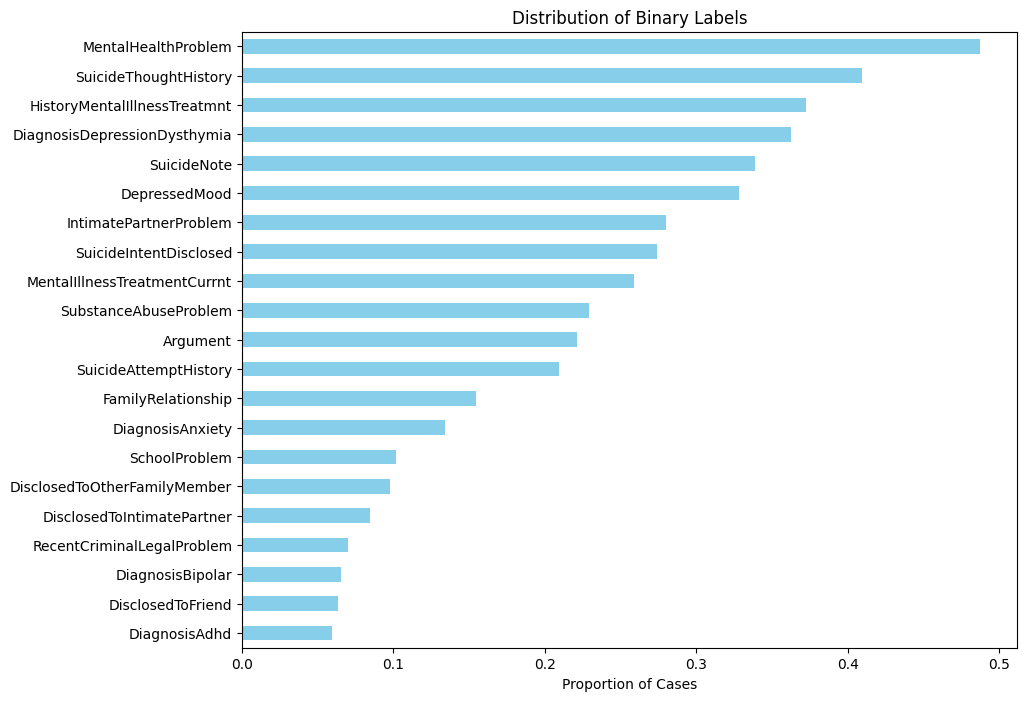

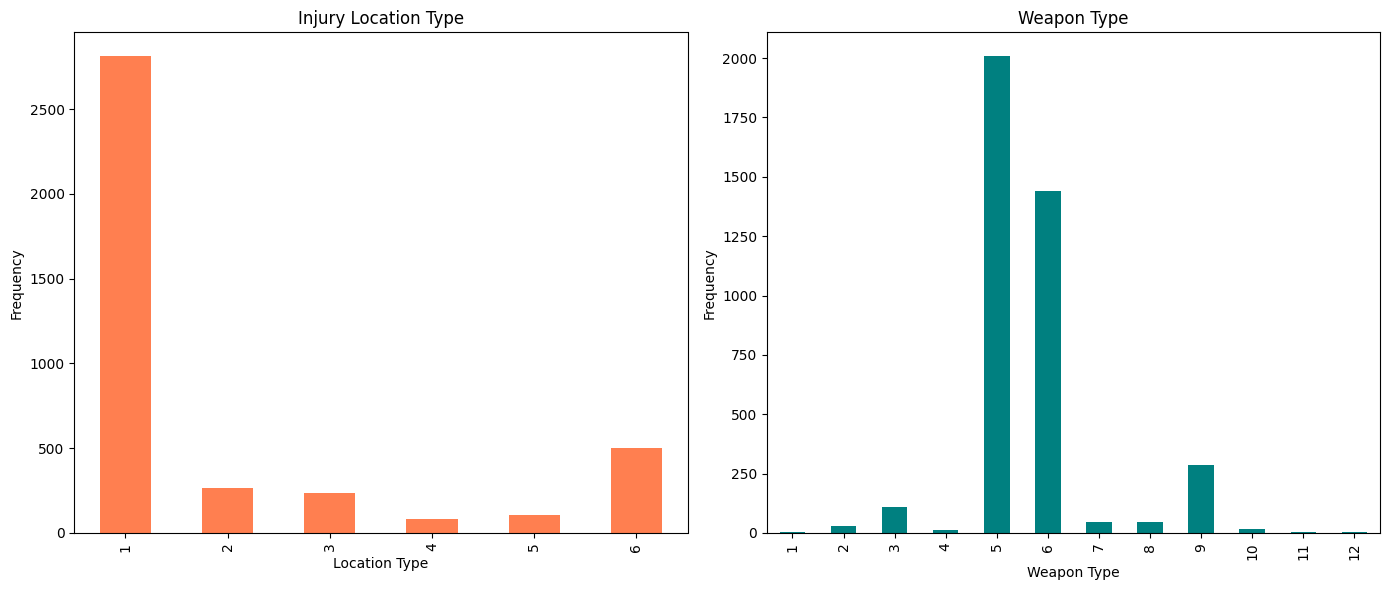

In [ ]:
import matplotlib.pyplot as plt

# Binary label distribution
binary_labels = labels.drop(columns=['InjuryLocationType', 'WeaponType1'])
binary_labels.mean().sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Distribution of Binary Labels")
plt.xlabel("Proportion of Cases")
plt.show()

# Categorical label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
labels['InjuryLocationType'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title("Injury Location Type")
axes[0].set_xlabel("Location Type")
axes[0].set_ylabel("Frequency")

labels['WeaponType1'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title("Weapon Type")
axes[1].set_xlabel("Weapon Type")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()


Text Data Analysis

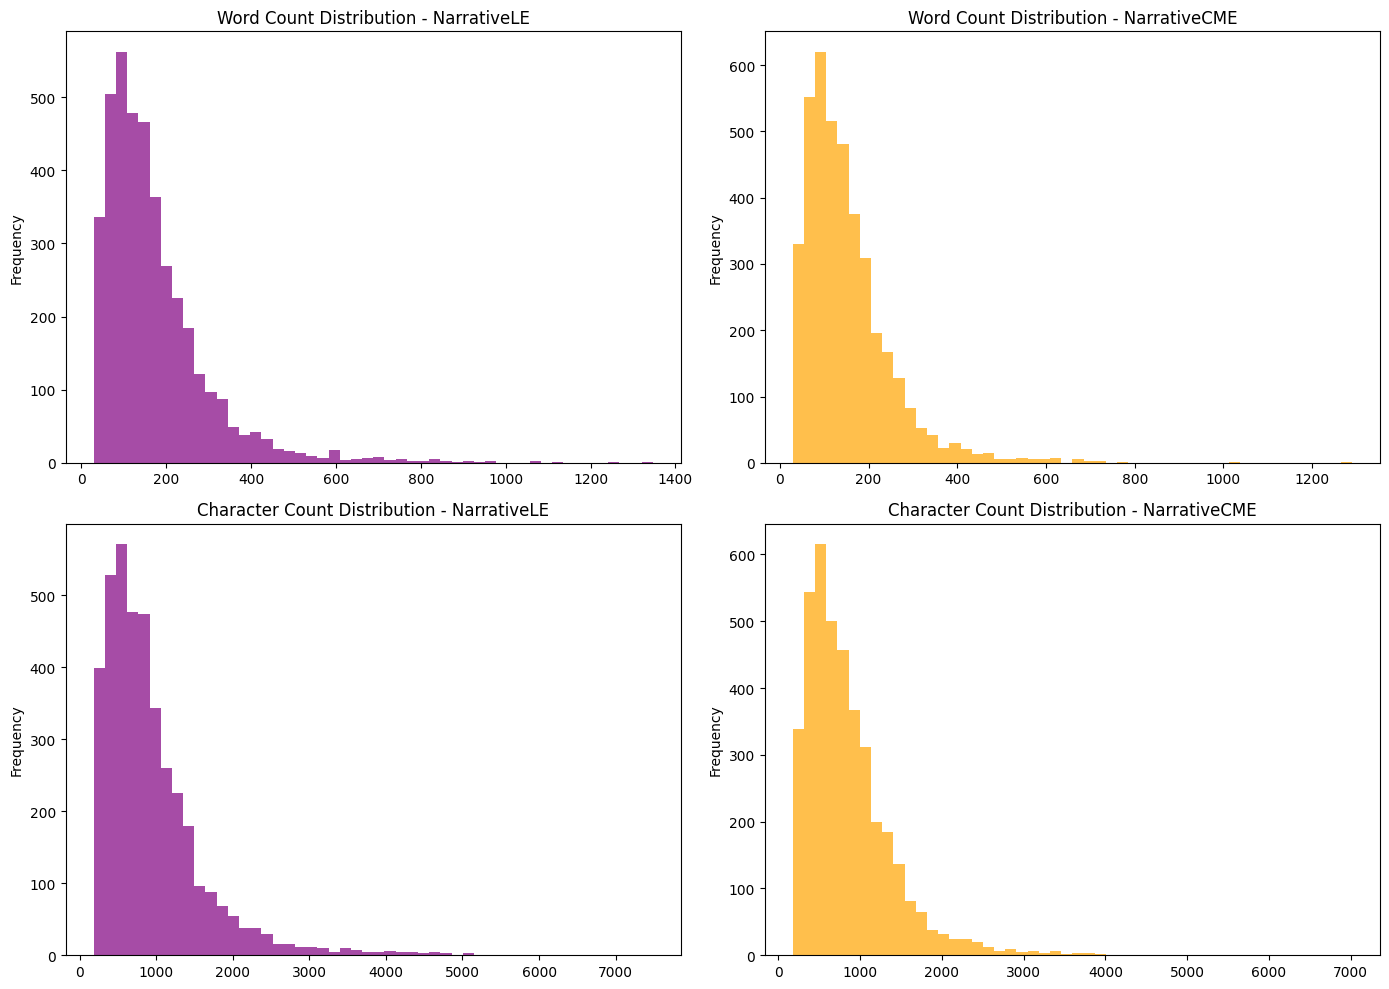

In [ ]:
# Add word count and character length columns
features['LE_WordCount'] = features['NarrativeLE'].str.split().apply(len)
features['LE_CharCount'] = features['NarrativeLE'].str.len()
features['CME_WordCount'] = features['NarrativeCME'].str.split().apply(len)
features['CME_CharCount'] = features['NarrativeCME'].str.len()

# Plot histograms for word counts and character lengths
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features['LE_WordCount'].plot(kind='hist', bins=50, ax=axes[0, 0], color='purple', alpha=0.7)
axes[0, 0].set_title("Word Count Distribution - NarrativeLE")
features['CME_WordCount'].plot(kind='hist', bins=50, ax=axes[0, 1], color='orange', alpha=0.7)
axes[0, 1].set_title("Word Count Distribution - NarrativeCME")

features['LE_CharCount'].plot(kind='hist', bins=50, ax=axes[1, 0], color='purple', alpha=0.7)
axes[1, 0].set_title("Character Count Distribution - NarrativeLE")
features['CME_CharCount'].plot(kind='hist', bins=50, ax=axes[1, 1], color='orange', alpha=0.7)
axes[1, 1].set_title("Character Count Distribution - NarrativeCME")

plt.tight_layout()
plt.show()


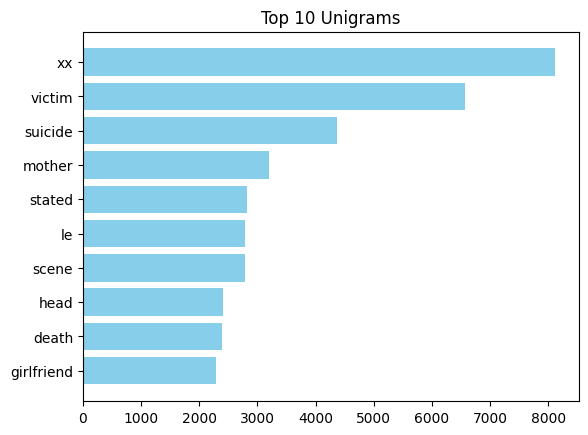

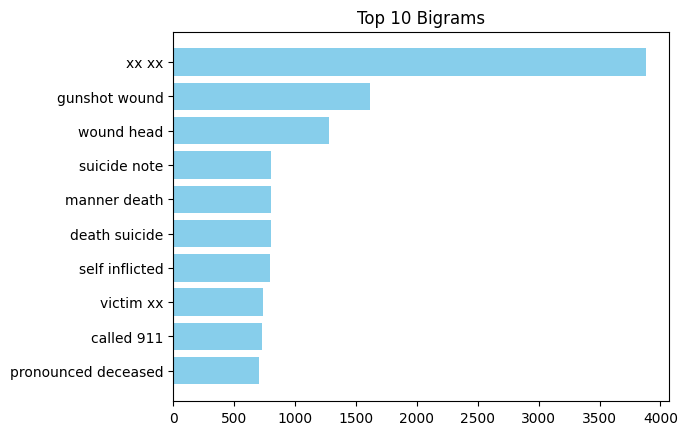

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to extract common n-grams
def plot_top_ngrams(corpus, ngram_range=(1,1), top_n=10):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    words, freqs = zip(*words_freq)
    plt.barh(words, freqs, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} {'Bigrams' if ngram_range == (2,2) else 'Unigrams'}")
    plt.show()

# Plot top unigrams and bigrams for NarrativeLE
plot_top_ngrams(features['NarrativeLE'].dropna(), ngram_range=(1,1), top_n=10)
plot_top_ngrams(features['NarrativeLE'].dropna(), ngram_range=(2,2), top_n=10)


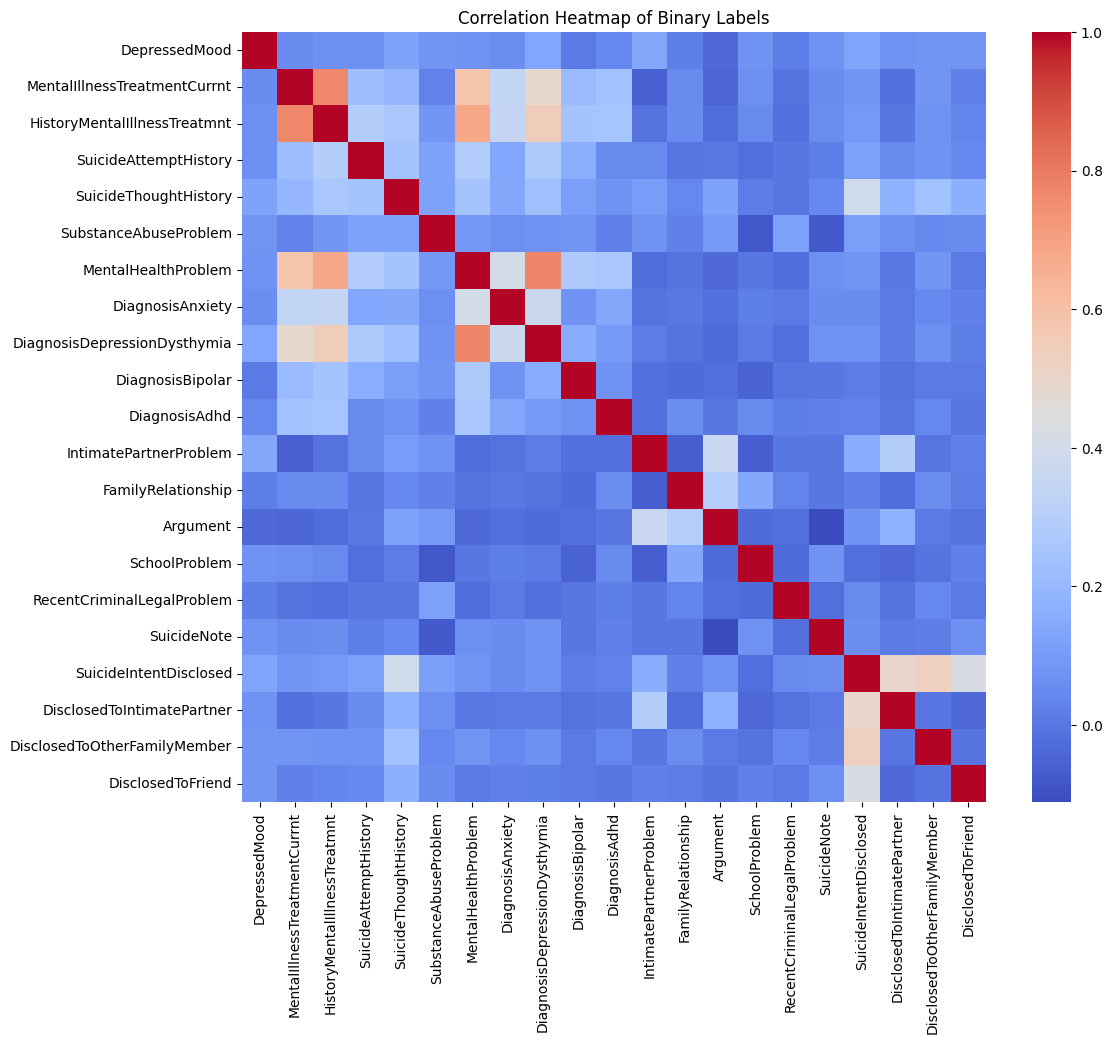

In [ ]:
import seaborn as sns

# Calculate correlation between labels
label_corr = binary_labels.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(label_corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Binary Labels")
plt.show()


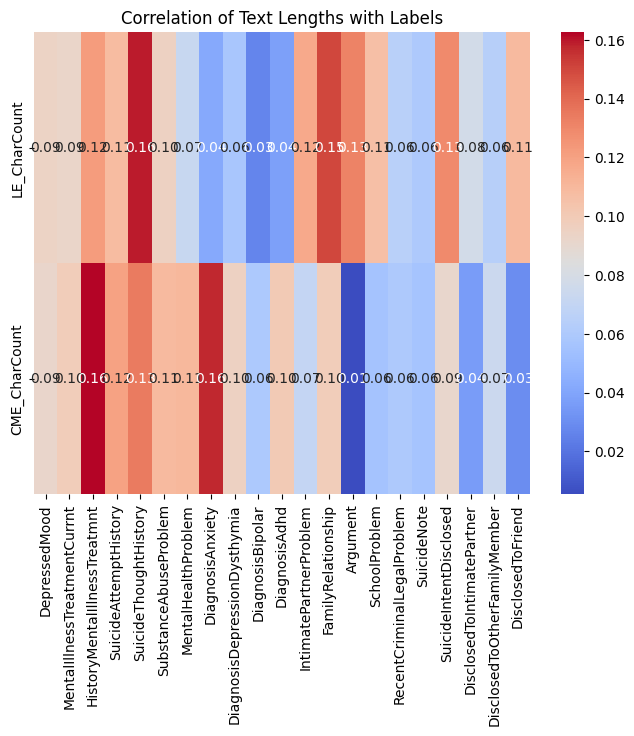

In [ ]:
# Correlation of text lengths with binary labels
text_lengths = features[['LE_CharCount', 'CME_CharCount']]
text_labels_corr = pd.concat([text_lengths, binary_labels], axis=1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(text_labels_corr.loc[['LE_CharCount', 'CME_CharCount'], binary_labels.columns], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Text Lengths with Labels")
plt.show()


In [ ]:
# Baseline accuracy by predicting the majority class for each label
baseline_accuracy = (1 - labels.mean()).round(2)  # Majority class accuracy for each label (0 is majority if mean < 0.5)
print("Baseline Accuracy by Predicting Majority Class for Each Label:")
print(baseline_accuracy)


Baseline Accuracy by Predicting Majority Class for Each Label:
DepressedMood                   0.67
MentalIllnessTreatmentCurrnt    0.74
HistoryMentalIllnessTreatmnt    0.63
SuicideAttemptHistory           0.79
SuicideThoughtHistory           0.59
SubstanceAbuseProblem           0.77
MentalHealthProblem             0.51
DiagnosisAnxiety                0.87
DiagnosisDepressionDysthymia    0.64
DiagnosisBipolar                0.93
DiagnosisAdhd                   0.94
IntimatePartnerProblem          0.72
FamilyRelationship              0.85
Argument                        0.78
SchoolProblem                   0.90
RecentCriminalLegalProblem      0.93
SuicideNote                     0.66
SuicideIntentDisclosed          0.73
DisclosedToIntimatePartner      0.92
DisclosedToOtherFamilyMember    0.90
DisclosedToFriend               0.94
InjuryLocationType             -0.98
WeaponType1                    -4.65
dtype: float64


In [ ]:
MODEL_DIR = Path("assets")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [ ]:
def save_model(device, model_name="mistralai/Mistral-7B-Instruct-v0.2"):
    logger.info(f"Using device {device} to save model to {MODEL_DIR}")

    # use 4-bit quantization
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
    )

    logger.info("Downloading model")
    model = AutoModelForCausalLM.from_pretrained(
        model_name, quantization_config=quantization_config, device_map=device
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    logger.info(f"Saving model to {MODEL_DIR}")
    model.save_pretrained(MODEL_DIR)
    tokenizer.save_pretrained(MODEL_DIR)
    logger.success("Model and tokenizer saved")

In [ ]:
if not (MODEL_DIR / "config.json").exists():
    logger.info("Downloading model")
    save_model(DEVICE)
else:
    logger.info("Using existing local model")

2024-10-31 12:23:41.104 | INFO     | __main__:<cell line: 1>:2 - Downloading model
2024-10-31 12:23:41.106 | INFO     | __main__:save_model:2 - Using device cuda to save model to assets
2024-10-31 12:23:41.108 | INFO     | __main__:save_model:10 - Downloading model


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

2024-10-31 12:30:48.494 | INFO     | __main__:save_model:16 - Saving model to assets
2024-10-31 12:33:17.304 | SUCCESS  | __main__:save_model:19 - Model and tokenizer saved


In [ ]:
logger.info(f"Loading model from {MODEL_DIR}, {MODEL_DIR.exists()}")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR, device_map=DEVICE, local_files_only=True
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

2024-10-31 12:42:09.112 | INFO     | __main__:<cell line: 1>:1 - Loading model from assets, True
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [ ]:

PROMPT_TEMPLATE = """You are an expert abstractor who reads law enforcement narratives about youth suicide and extracts variables that represent common patterns. The variables you are extracting are either binary (0 or 1) or categorical. Use the example input and output for the list of all variables to return.

There are two categorical variables, specified below. For categorical variables, return ONE of the possible values specified in the semicolon-separated list.
VARIABLE: InjuryLocationType
- POSSIBLE VALUES: House, apartment; Motor vehicle (excluding school bus and public transportation); Natural area (e.g., field, river, beaches, woods); Street/road, sidewalk, alley; Park, playground, public use area; Other
VARIABLE: WeaponType1
- POSSIBLE VALUES: Firearm; Hanging, strangulation, suffocation; Poisoning; Fall; Other transport vehicle, eg, trains, planes, boats; Motor vehicle including buses, motorcycles; Drowning; Sharp instrument; Fire or burns; Blunt instrument; Unknown; Other (e.g. taser, electrocution, nail gun)

All other variables are binary. For binary variables, Return a 0 if the item represented by the variable is absent and 1 if the item represented by the variable is present. The binary variables are:
- DepressedMood
- MentalIllnessTreatmentCurrnt
- HistoryMentalIllnessTreatmnt
- SuicideAttemptHistory
- SuicideThoughtHistory
- SubstanceAbuseProblem
- MentalHealthProblem
- DiagnosisAnxiety
- DiagnosisDepressionDysthymia
- DiagnosisBipolar
- DiagnosisAdhd
- IntimatePartnerProblem
- FamilyRelationship
- Argument
- SchoolProblem
- RecentCriminalLegalProblem
- SuicideNote
- SuicideIntentDisclosed
- DisclosedToIntimatePartner
- DisclosedToOtherFamilyMember
- DisclosedToFriend

You should output properly formatted json object where the keys are variable names and the values are predicted values for the given narrative. Do NOT output anything other than the JSON object. Do not include any explanation or summaries. Do not include any keys in this json object that aren't specified in the list.
-------------
EXAMPLE INPUT:
XX XX V found deceased at home by his grandparents, hanging from a basketball hoop in his basement family room. According to LE, a check of V's cell phone revealed that V had made suicidal statements by phone earlier. In the text message V sent to his girlfriend, he had stated that he was going to hang himself.

EXAMPLE OUTPUT:
{{"DepressedMood": 0,
 "MentalIllnessTreatmentCurrnt": 0,
 "HistoryMentalIllnessTreatmnt": 0,
 "SuicideAttemptHistory": 0,
 "SuicideThoughtHistory": 0,
 "SubstanceAbuseProblem": 0,
 "MentalHealthProblem": 0,
 "DiagnosisAnxiety": 0,
 "DiagnosisDepressionDysthymia": 0,
 "DiagnosisBipolar": 0,
 "DiagnosisAdhd": 0,
 "IntimatePartnerProblem": 0,
 "FamilyRelationship": 0,
 "Argument": 0,
 "SchoolProblem": 0,
 "RecentCriminalLegalProblem": 0,
 "SuicideNote": 0,
 "SuicideIntentDisclosed": 1,
 "DisclosedToIntimatePartner": 1,
 "DisclosedToOtherFamilyMember": 0,
 "DisclosedToFriend": 0,
 "InjuryLocationType": "House, apartment",
 "WeaponType1": "Hanging, strangulation, suffocation"
}}
-------------
INPUT:
{}

OUTPUT:
"""

In [ ]:
def process_features(features):
    """
    Order features by ascending string length
    """
    features["str_len"] = features.NarrativeLE.str.len()
    features = features.sort_values(by="str_len")
    return features.drop(columns=["str_len"])
def batch_features(features, batch_size: int):
    """
    Batch features together
    """
    if len(features) > batch_size:
        return np.array_split(features, int(len(features) / batch_size))
    return [features]

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
BATCH_SIZE = 10
MAX_NEW_TOKENS=300

In [ ]:
def predict_on_batch(feature_batch, model, tokenizer):
    """
    Tokenize input batches, generate and decode outputs
    """
    # Tokenize input narratives (NarrativeLE) in batch
    prompts = [PROMPT_TEMPLATE.format(nar) for nar in feature_batch.NarrativeLE]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True)
    inputs.to("cuda")

    # Generate outputs for variables
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=MAX_NEW_TOKENS,
    )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Remove prompt from output
    decoded = [resp[len(prompt) :] for resp, prompt in zip(decoded, prompts)]

    return decoded

In [ ]:
# Batch inputs - note - we're running an example of 5 in this notebook
df = process_features(features.iloc[:5])
data_batches = batch_features(df, BATCH_SIZE)

responses = []
idxs = []
logger.info(f"Iterating over {len(data_batches)} batches")
for ix, data_batch in enumerate(data_batches):
    logger.info(f"Generating predictions on batch {ix}, with {len(data_batch)} samples")
    responses += predict_on_batch(data_batch, model, tokenizer)
    idxs += list(data_batch.index)
logger.info(f"Finished inference")
interim_preds = pd.DataFrame({"string_output": responses}, index=df.index)

<ipython-input-26-bb5ae7b86199>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["str_len"] = features.NarrativeLE.str.len()
2024-10-31 12:45:06.541 | INFO     | __main__:<cell line: 7>:7 - Iterating over 1 batches
2024-10-31 12:45:06.543 | INFO     | __main__:<cell line: 8>:9 - Generating predictions on batch 0, with 5 samples
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2024-10-31 12:46:25.995 | INFO     | __main__:<cell line: 12>:12 - Finished inference


In [ ]:
print(responses[0])

{"DepressedMood": 1,
 "MentalIllnessTreatmentCurrnt": 0,
 "HistoryMentalIllnessTreatmnt": 0,
 "SuicideAttemptHistory": 1,
 "SuicideThoughtHistory": 1,
 "SubstanceAbuseProblem": 0,
 "MentalHealthProblem": 0,
 "DiagnosisAnxiety": 0,
 "DiagnosisDepressionDysthymia": 0,
 "DiagnosisBipolar": 0,
 "DiagnosisAdhd": 0,
 "IntimatePartnerProblem": 0,
 "FamilyRelationship": 0,
 "Argument": 0,
 "SchoolProblem": 0,
 "RecentCriminalLegalProblem": 0,
 "SuicideNote": 0,
 "SuicideIntentDisclosed": 1,
 "DisclosedToIntimatePartner": 0,
 "DisclosedToOtherFamilyMember": 0,
 "DisclosedToFriend": 0,
 "InjuryLocationType": "Motor vehicle",
 "WeaponType1": "Firearm"
}


In [ ]:
def parse_response(output):
    """
    Transform response into a json object using minimal cleaning
    """
    try:
        # Try loading the raw string into
        resp = json.loads(output)
        return resp
    except json.JSONDecodeError:
        pass
    try:
        # Get rid of extra trailing sections that follow "--"
        split_output = output.split("--")[0]
        resp = json.loads(split_output)
        return resp
    except json.JSONDecodeError:
        pass
    try:
        # Get rid of sections that follow the a closing bracket "}"
        split_output = output.split("}")[0] + "}"
        resp = json.loads(split_output)
        return resp
    except json.JSONDecodeError:
        logger.warning(f"Failed to parse {output} into valid json")
        return None

In [ ]:
def process_injury_location(data: pd.Series):
    """
    Transform InjuryLocationType model output to integers,
    fill in default for invalid outputs
    """
    ilt = data.map(
        {
            "House, apartment": 1,
            "Motor vehicle (excluding school bus and public transportation)": 2,
            "Natural area (e.g., field, river, beaches, woods)": 3,
            "Park, playground, public use area": 4,
            "Street/road, sidewalk, alley": 5,
            "Other": 6,
            "Residence": 1,
            "Apartment": 1,
        }
    )
    if ilt.isna().any():
        logger.warning(
            f"There are unexpected values in injury location: {data[ilt.isna()].unique()} "
        )
        ilt = ilt.fillna(6)  # Fill with other

    return ilt.astype(int)


def process_weapon_type(data: pd.Series):
    """
    Transform WeaponType1 model output to integers,
    fill in default for invalid outputs
    """
    wt = data.map(
        {
            "Blunt instrument": 1,
            "Drowning": 2,
            "Fall": 3,
            "Fire or burns": 4,
            "Firearm": 5,
            "Hanging, strangulation, suffocation": 6,
            "Motor vehicle including buses, motorcycles": 7,
            "Other transport vehicle, eg, trains, planes, boats": 8,
            "Poisoning": 9,
            "Sharp instrument": 10,
            "Other (e.g. taser, electrocution, nail gun)": 11,
            "Unknown": 12,
        }
    )
    if wt.isna().any():
        logger.warning(
            f"There are unexpected values in weapon type: {data[wt.isna()].unique()} "
        )
        wt = wt.fillna(11)  # Fill with other

    return wt.astype(int)

In [ ]:
idxs = []
parsed_resps = []
could_not_parse = []

for row in interim_preds.itertuples():
    parsed = parse_response(row.string_output)
    if type(parsed) == dict:
        idxs.append(row.Index)
        parsed_resps.append(parsed)
    else:
        idxs.append(row.Index)
        could_not_parse.append(row.Index)
        # Fill any we couldn't parse with placeholder values for now
        parsed_resps.append(
            {
                "DepressedMood": 0,
                "IntimatePartnerProblem": 0,
                "FamilyRelationship": 0,
                "Argument": 0,
                "MentalIllnessTreatmentCurrnt": 0,
                "HistoryMentalIllnessTreatmnt": 0,
                "SuicideAttemptHistory": 0,
                "SuicideThoughtHistory": 0,
                "SuicideNote": 0,
                "SubstanceAbuseProblem": 0,
                "SchoolProblem": 0,
                "RecentCriminalLegalProblem": 0,
                "SuicideIntentDisclosed": 0,
                "DisclosedToIntimatePartner": 0,
                "DisclosedToOtherFamilyMember": 0,
                "DisclosedToFriend": 0,
                "MentalHealthProblem": 0,
                "DiagnosisAnxiety": 0,
                "DiagnosisDepressionDysthymia": 0,
                "DiagnosisBipolar": 0,
                "DiagnosisAdhd": 0,
                "WeaponType1": "Unknown",
                "InjuryLocationType": "Other",
            }
        )

if len(could_not_parse) > 0:
    logger.warning(
        f"Could not parse {len(could_not_parse)} rows. Indices: {could_not_parse}"
    )

parsed_preds = pd.DataFrame(parsed_resps, index=pd.Index(idxs, name="uid")).fillna(0)
parsed_preds["InjuryLocationType"] = process_injury_location(
    parsed_preds.InjuryLocationType
)
parsed_preds["WeaponType1"] = process_weapon_type(parsed_preds.WeaponType1)

# Make sure the column order is the same as in the submission format
parsed_preds = parsed_preds[submission_format.columns]

# Make sure the row order is the same as in the submission format
parsed_preds = parsed_preds.loc[features[:5].index]

# Make sure all values are int
parsed_preds = parsed_preds.round().astype(int)

2024-10-31 12:48:59.694 | WARNING  | __main__:process_injury_location:19 - There are unexpected values in injury location: ['Motor vehicle'] 


In [ ]:
parsed_preds.head()

,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,SubstanceAbuseProblem,MentalHealthProblem,DiagnosisAnxiety,DiagnosisDepressionDysthymia,DiagnosisBipolar,...,Argument,SchoolProblem,RecentCriminalLegalProblem,SuicideNote,SuicideIntentDisclosed,DisclosedToIntimatePartner,DisclosedToOtherFamilyMember,DisclosedToFriend,InjuryLocationType,WeaponType1
uid,,,,,,,,,,,,,,,,,,,,,
aaaf,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,6,5
aaby,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
aacl,1,0,0,1,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,5
aacn,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
aadb,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,6


In [ ]:
assert (submission_format.columns == parsed_preds.columns).all().all()
# All columns are of type int
assert (parsed_preds.dtypes == int).all()
# Variables have values within the expected range
assert parsed_preds.iloc[:, 0:-2].isin([0, 1]).all().all()
assert (parsed_preds["InjuryLocationType"].isin(range(1, 7))).all()
assert (parsed_preds["WeaponType1"].isin(range(1, 13))).all()